In [13]:
%matplotlib inline

import numpy as np
import casadi as ca
import matplotlib.pyplot as plt

from operator import itemgetter

In [16]:
nk = 100    # Control discretization
tf = 10.0  # End time

# Declare variables (use scalar graph)
u  = ca.SX.sym( 'u' )     # control
x  = ca.SX.sym( 'x', 3 )  # states

This notebook will try to solve third order system in form of:
$$ \dddot x + \ddot x + \dot x + x - u = 0 $$
Or alternatively in the 1st order form:
$$\begin{cases}
\dot x_0 = -x_0 - x_1 - x_2 + u \\
\dot x_1 = x_0 \\
\dot x_2 = x_1
\end{cases}
$$
Subject to:
$$ \min \int_{0}^{T}x_2^2 + u^2 \,dx  $$

In [17]:
# ODE right hand side and quadratures
xdot = ca.vertcat( [-x[0] - x[1] - x[2] + u, x[0], x[1]] )
qdot = x[1]*x[1] + x[2]*x[2] + u*u

# DAE residual function
dae = ca.SXFunction("dae", ca.daeIn(x=x, p=u), ca.daeOut(ode=xdot, quad=qdot))

# Create an integrator
integrator = ca.Integrator("integrator", "cvodes", dae, {"tf":tf/nk})

# All controls (use matrix graph)
x = ca.MX.sym("x",nk) # nk-by-1 symbolic variable
U = ca.vertsplit(x) # cheaper than x[0], x[1], ...

# The initial state (x_0=0, x_1=1)
X  = ca.MX([0,1, 1])

In [18]:
# Objective function
f = 0

# Build a graph of integrator calls
for k in range(nk):
  X,QF = itemgetter('xf','qf')(integrator( {'x0':X, 'p':U[k] } ) )
  f += QF

# Terminal constraints: x_0(T)=x_1(T)=0
g = X

# Allocate an NLP solver
opts = {'linear_solver': 'ma27'}
nlp = ca.MXFunction("nlp", ca.nlpIn(x=x), ca.nlpOut(f=f,g=g))
solver = ca.NlpSolver("solver", "ipopt", nlp, opts)

# Solve the problem
sol = solver({"lbx" : -0.75,
              "ubx" : 1,
              "x0" : 0,
              "lbg" : 0,
              "ubg" : 0})


This is Ipopt version 3.11.4, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:      300
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     5050

Total number of variables............................:      100
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      100
                     variables with only upper bounds:        0
Total number of equality constraints.................:        3
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.5746930e+01 1.24e+00 8.37e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1

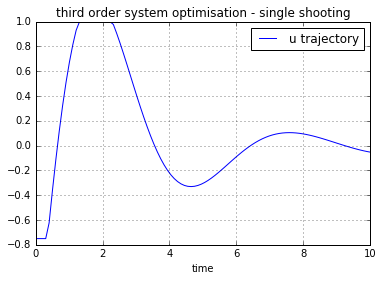

In [21]:
# Retrieve the solution
u_opt = np.array(sol["x"])

# Time grid
tgrid_x = np.linspace(0,10,nk+1)
tgrid_u = np.linspace(0,10,nk)

# Plot the results
plt.figure(1)
plt.clf()
plt.plot(tgrid_u,u_opt,'b-')
plt.title("third order system optimisation - single shooting")
plt.xlabel('time')
plt.legend(['u trajectory'])
plt.grid()

In [20]:
sol

{'f': DMatrix(8.87629),
 'g': DMatrix([1.39746e-10, 1.09567e-10, -1.398e-10]),
 'lam_g': DMatrix([0.110401, 0.0226479, -0.131415]),
 'lam_p': DMatrix([]),
 'lam_x': DMatrix([-0.211563, -0.149845, -0.0893594, -0.0307915, -1.83113e-08, -4.56424e-09, -1.67147e-09, -5.72598e-11, 1.3693e-09, 3.11134e-09, 5.87477e-09, 1.17424e-08, 3.43192e-08, 0.00508942, 0.0198351, 0.0303988, 0.0369898, 0.03985, 0.0392519, 0.0354936, 0.0288924, 0.019779, 0.00849164, 1.12069e-07, 2.45207e-08, 1.27115e-08, 8.01601e-09, 5.49163e-09, 3.9009e-09, 2.78811e-09, 1.94607e-09, 1.26688e-09, 6.88711e-10, 1.73644e-10, -3.0261e-10, -7.55789e-10, -1.19523e-09, -1.62547e-09, -2.04678e-09, -2.45501e-09, -2.84231e-09, -3.19764e-09, -3.50827e-09, -3.76135e-09, -3.94615e-09, -4.05614e-09, -4.09002e-09, -4.05195e-09, -3.95044e-09, -3.79698e-09, -3.60426e-09, -3.38448e-09, -3.14846e-09, -2.90511e-09, -2.66138e-09, -2.42227e-09, -2.19131e-09, -1.97082e-09, -1.76221e-09, -1.56626e-09, -1.38336e-09, -1.21362e-09, -1.05701e-09, -9.1